In [96]:
#!/usr/bin/env python
"""
NVDA Daily Close Forecasting & Trading Strategy
Author : <your-name>  |  Created : 2025-07-20
Reproducibility : All seeds set to 42.

Usage:
    python nvda_forecasting.py
Outputs:
    - metrics_summary.csv
    - figs/  (prediction plots, residuals, equity curves)
"""

# ── Imports ──────────────────────────────────────────────────────────────
import os, time, warnings, logging, math, random, pathlib
from functools import partial
import numpy  as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from ta import momentum, trend, volatility
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import optuna
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from neuralprophet import NeuralProphet

SEED = 42
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)



In [ ]:
# ── Constants ────────────────────────────────────────────────────────────
TICKER      = "NVDA"
START_DATE  = "2010-01-01"
END_DATE    = "2025-07-20"
FIG_DIR     = pathlib.Path("figs")
FIG_DIR.mkdir(exist_ok=True)
VAL_YEARS   = list(range(2021, 2024))   # 2019 … 2024 inclusive
TEST_YEAR   = list(range(2024,2025))                      # untouched OOS

# ── Utils ────────────────────────────────────────────────────────────────
def log_time(func):
    """Decorator that prints function runtime."""
    def wrapper(*args, **kwargs):
        beg = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed = time.perf_counter() - beg
        logging.info(f"{func.__name__}() finished in {elapsed:.2f}s")
        return result
    return wrapper

def sharpe_ratio(returns, freq=252, eps=0.04):
    """Annualised Sharpe assuming rf=0."""
    mu = returns.mean()*freq - eps*freq
    sigma = returns.std()*math.sqrt(freq)+eps
    return mu/sigma




In [55]:
# ── 1. Data Download & Cleaning ──────────────────────────────────────────
@log_time
def download_data():
    df = yf.download(
        TICKER,
        START_DATE,
        END_DATE,
        group_by='column',       # <- ensures single‑level cols
        progress=False,
        auto_adjust=True,        # <- uses adjusted close
    )

    # If someone runs the script with group_by='ticker' by mistake,
    # or passes a list of tickers, we still normalise here:
    if isinstance(df.columns, pd.MultiIndex):
        # Drop the first level (“Ticker”) and keep only the actual field names
        df = df.xs(TICKER, axis=1, level=1)        # (n_rows × 6) DataFrame

    df = df.rename(columns={
        'Open'     : 'open',
        'High'     : 'high',
        'Low'      : 'low',
        'Close'    : 'close',      # adjusted close
        'Volume'   : 'volume'
    })

    df = df[['open', 'high', 'low', 'close', 'volume']]
    df = df.ffill()

    # Double‑check: no duplicate labels & all Series
    assert not df.columns.duplicated().any()
    for c in df.columns:
        assert isinstance(df[c], pd.Series)

    return df


In [56]:
df = download_data()

2025-07-21 22:31:08,947 download_data() finished in 0.05s


In [57]:
start_date = pd.Timestamp('2024-01-01')
df_filtered = df[df.index >= start_date]

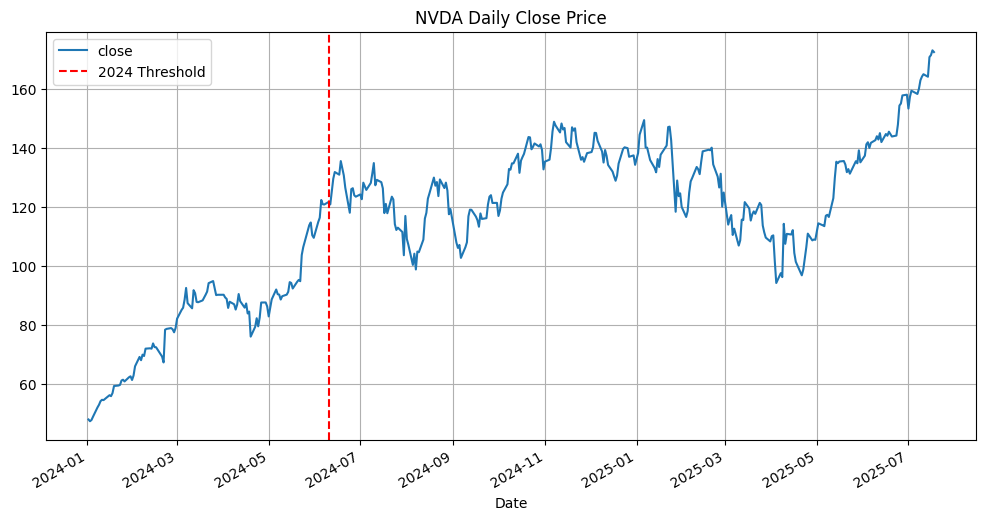

In [58]:
# Filter data after 2024-01-01 and create plot
df_filtered["close"].plot(figsize=(12, 6), title="NVDA Daily Close Price")
plt.axvline(x='2024-06-10', color='r', linestyle='--', label='2024 Threshold')
plt.legend()
plt.grid(True)

<Axes: title={'center': 'NVDA Daily Close Price'}, xlabel='Date'>

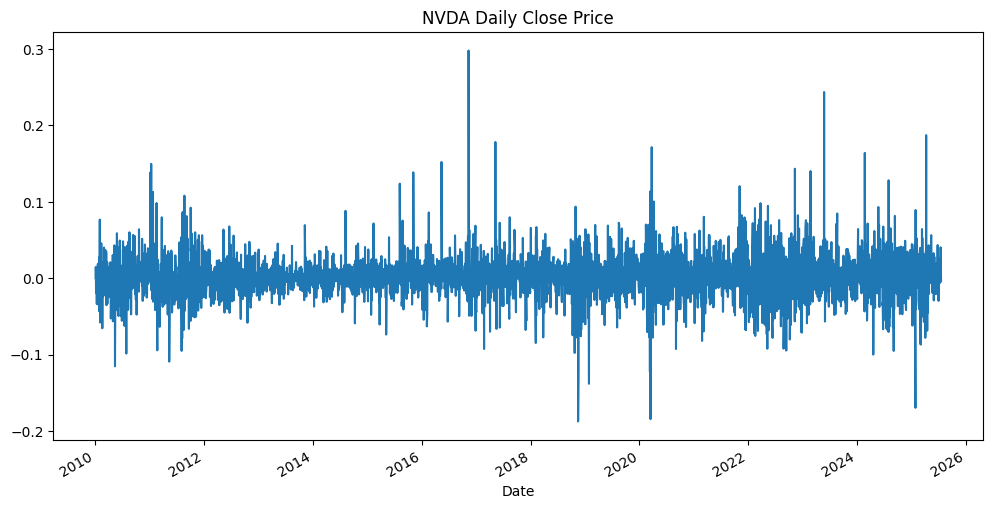

In [59]:
df["close_pct"] = df["close"].pct_change().fillna(0)
df["close_pct"].plot(figsize=(12, 6), title="NVDA Daily Close Price")

In [60]:
df["close_pct"].describe()

count    3909.000000
mean        0.001955
std         0.028988
min        -0.187559
25%        -0.012436
50%         0.001788
75%         0.016321
max         0.298067
Name: close_pct, dtype: float64

In [82]:

# ── 2. Feature Engineering ───────────────────────────────────────────────
@log_time
def make_features(df_raw: pd.DataFrame)->pd.DataFrame:
    df = df_raw.copy()
    # Returns
    df["ret"] = df["close"].pct_change()
    for lag in (1,5,10):
        df[f"ret_lag{lag}"] = df["ret"].shift(lag)
    # Rolling stats
    for win in (20,50):
        df[f"roll_mean_{win}"] = df["close"].rolling(win).mean()
        df[f"roll_std_{win}"]  = df["close"].rolling(win).std()

    close = df['close']           # 1‑D Series guaranteed

    # Technical indicators (ta)
    df['rsi_14'] = momentum.RSIIndicator(
        close=close.astype(float),  # cast just in case
        window=14
    ).rsi()
    macd = trend.MACD(df["close"])
    df["macd"]     = macd.macd_diff()
    # Bollinger band width
    bb = volatility.BollingerBands(df["close"])
    df["bb_width"] = bb.bollinger_wband()
    # ATR
    df["atr_14"]   = volatility.AverageTrueRange(df["high"],df["low"],
                                                 df["close"],14).average_true_range()
    # Calendar dummies
    df["dow"]   = df.index.dayofweek
    df["month"] = df.index.month
    df = pd.get_dummies(df, columns=["dow","month"], drop_first=True)
    # Target
    df["target"] = df["close"].shift(-1)  # next-day close
    return df.dropna()


In [83]:

# ── 3. Dataset helpers ──────────────────────────────────────────────────
def split_by_year(df, end_year):
    """Return train<=end_year-1, val=end_year dataframes."""
    train = df[df.index.year <  end_year].copy()
    val   = df[df.index.year == end_year].copy()
    return train, val

class SeqDataset(Dataset):
    """LSTM dataset (uses features not including target)."""
    def __init__(self, df, seq_len=20):
        self.X = df.drop(columns=["target"]).values.astype(np.float32)
        self.y = df["target"].values.astype(np.float32)
        self.seq_len = seq_len
    def __len__(self): return len(self.y)-self.seq_len
    def __getitem__(self, idx):
        sl = slice(idx, idx+self.seq_len)
        return (self.X[sl], self.y[idx+self.seq_len])

class LSTMRegressor(nn.Module):
    def __init__(self, n_features:int, hidden:int, layers:int, dropout:float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

# keys that belong to the architecture
ARCH_KEYS = ["hidden", "layers", "dropout"]
def arch_only(cfg: dict) -> dict:
    return {k: cfg[k] for k in ARCH_KEYS}


In [84]:
# ── 4. Hyper-parameter Search ───────────────────────────────────────────
@log_time
def tune_random_forest(train_X, train_y, val_X, val_y):
    def objective(trial):
        rf = RandomForestRegressor(
            n_estimators    =trial.suggest_int("n_estimators", 100, 600),
            max_depth       =trial.suggest_int("max_depth", 3, 20),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            random_state=SEED,n_jobs=-1)
        rf.fit(train_X, train_y)
        preds = rf.predict(val_X)
        return mean_squared_error(val_y, preds, squared=False)  # RMSE
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, show_progress_bar=False)
    return study.best_params

@log_time
def tune_lstm(train_df, val_df, seq_len):
    n_features = train_df.drop(columns=["target"]).shape[1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def objective(trial):
        cfg = {
            "hidden" : trial.suggest_int("hidden", 32,128),
            "layers" : trial.suggest_int("layers", 1, 3),
            "dropout": trial.suggest_float("dropout", 0.0, 0.5),
            "lr"     : trial.suggest_loguniform("lr",1e-4,1e-2),
            "epochs" : 10          # fixed during tuning
        }

        model = LSTMRegressor(n_features, **arch_only(cfg)).to(device)
        loss_fn = nn.MSELoss()
        optim   = torch.optim.Adam(model.parameters(), lr=cfg["lr"])

        tr_ds = SeqDataset(train_df, seq_len)
        tr_ld = DataLoader(tr_ds, batch_size=32, shuffle=False)

        model.train()
        for _ in range(cfg["epochs"]):
            for X,y in tr_ld:
                X, y = X.to(device), y.to(device)
                optim.zero_grad()
                loss_fn(model(X), y).backward()
                optim.step()

        # ---- validation
        va_ds = SeqDataset(val_df, seq_len)
        with torch.no_grad():
            preds = []
            for i in range(len(va_ds)):
                X,_ = va_ds[i]
                p = model(torch.tensor(X).unsqueeze(0).to(device)).item()
                preds.append(p)
        rmse = mean_squared_error(
            val_df["target"].values[seq_len:], preds, squared=False
        )
        return rmse

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(objective, n_trials=30, show_progress_bar=False)

    best = study.best_params        # hidden, layers, dropout, lr
    best["epochs"] = 25             # extend for real training
    return best

In [89]:

# ── 5. Model wrappers ───────────────────────────────────────────────────
def build_models(best_rf_params, n_features):
    lin = Pipeline([
        ("scaler", StandardScaler()),
        ("pca"   , PCA(n_components=0.95, random_state=SEED)),
        ("linreg", LinearRegression())
    ])

    rf = RandomForestRegressor(
        **best_rf_params, random_state=SEED, n_jobs=-1
    )

    np_mod = NeuralProphet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False,
        n_changepoints=15,
        learning_rate=0.001,
        epochs=150
    )
    return lin, rf, np_mod



In [90]:
# ── 6. Walk-Forward Evaluation ──────────────────────────────────────────
@log_time
def walk_forward(df, seq_len, best_rf_params, lstm_cfg):
    n_features = df.drop(columns=["target"]).shape[1]
    lin, rf, _ = build_models(best_rf_params, n_features)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    rows = []
    for yr in VAL_YEARS:
        tr, va = split_by_year(df, yr)
        X_tr, y_tr = tr.drop(columns=["target"]), tr["target"]
        X_va, y_va = va.drop(columns=["target"]), va["target"]

        # Linear
        lin.fit(X_tr, y_tr)
        pred_lin = lin.predict(X_va)

        # Random‑Forest
        rf.fit(X_tr, y_tr)
        pred_rf = rf.predict(X_va)

        # LSTM
        lstm = LSTMRegressor(n_features, **arch_only(lstm_cfg)).to(device)
        optim = torch.optim.Adam(lstm.parameters(), lr=lstm_cfg["lr"])
        loss_fn = nn.MSELoss()
        tr_ld = DataLoader(SeqDataset(tr, seq_len), batch_size=64, shuffle=False)
        lstm.train()
        for _ in range(lstm_cfg["epochs"]):
            for Xb,yb in tr_ld:
                Xb,yb = Xb.to(device), yb.to(device)
                optim.zero_grad()
                loss_fn(lstm(Xb), yb).backward()
                optim.step()

        lstm.eval()
        preds_lstm = []
        va_ds = SeqDataset(va, seq_len)
        with torch.no_grad():
            for i in range(len(va_ds)):
                X,_ = va_ds[i]
                p = lstm(torch.tensor(X).unsqueeze(0).to(device)).item()
                preds_lstm.append(p)

        # NeuralProphet
        df_np = tr[["target"]].rename(columns={"target":"y"})
        df_np["ds"] = df_np.index
        np_mod = NeuralProphet()
        np_mod.fit(df_np, freq="D", progress="off")
        df_future = np_mod.make_future_dataframe(
            df_np, periods=len(va), n_historic_predictions=False
        )
        forecast = np_mod.predict(df_future)
        pred_np  = forecast["yhat1"].values

        # ---- metrics helper
        def _metrics(y_true, y_pred):
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            mae  = mean_absolute_error(y_true, y_pred)
            mape = mean_absolute_percentage_error(y_true, y_pred)
            hit  = (np.sign(np.diff(y_pred,prepend=y_pred[0])) ==
                    np.sign(np.diff(y_true,prepend=y_true[0]))).mean()
            strat = (np.sign(np.diff(y_pred,prepend=y_pred[0]))[:-1] > 0) * \
                    np.diff(y_true,prepend=y_true[0])[:-1]
            sharpe = sharpe_ratio(pd.Series(strat))
            return rmse, mae, mape, hit, sharpe

        rows.extend([
            ("LIN", yr, *_metrics(y_va, pred_lin)),
            ("RF" , yr, *_metrics(y_va, pred_rf)),
            ("LSTM",yr, *_metrics(y_va.iloc[seq_len:], preds_lstm)),
            ("NP" , yr, *_metrics(y_va, pred_np)),
        ])

    return pd.DataFrame(rows, columns=[
        "model","year","rmse","mae","mape","hit","sharpe"
    ])

In [91]:
# ── 7. OOS test & strategy ─────────────────────────────────────────────
def test_best_model(df, best_name, best_rf_params, lstm_cfg, seq_len):
    n_feat = df.drop(columns=["target"]).shape[1]
    lin, rf, _ = build_models(best_rf_params, n_feat)
    train = df[df.index.year < TEST_YEAR]
    test  = df[df.index.year == TEST_YEAR]
    X_tr, y_tr = train.drop(columns=["target"]), train["target"]
    X_te, y_te = test.drop(columns=["target"]),  test["target"]

    if best_name == "LIN":
        mdl = lin.fit(X_tr, y_tr)
        preds = mdl.predict(X_te)

    elif best_name == "RF":
        mdl = rf.fit(X_tr, y_tr)
        preds = mdl.predict(X_te)

    elif best_name == "LSTM":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        lstm = LSTMRegressor(n_feat, **arch_only(lstm_cfg)).to(device)
        optim = torch.optim.Adam(lstm.parameters(), lr=lstm_cfg["lr"])
        loss_fn = nn.MSELoss()
        tr_ld = DataLoader(SeqDataset(train, seq_len), batch_size=64, shuffle=False)
        lstm.train()
        for _ in range(lstm_cfg["epochs"]):
            for Xb,yb in tr_ld:
                Xb,yb = Xb.to(device), yb.to(device)
                optim.zero_grad()
                loss_fn(lstm(Xb), yb).backward()
                optim.step()
        lstm.eval()
        preds = []
        te_ds = SeqDataset(test, seq_len)
        with torch.no_grad():
            for i in range(len(te_ds)):
                X,_ = te_ds[i]
                preds.append(
                    lstm(torch.tensor(X).unsqueeze(0).to(device)).item()
                )

    else:  # NeuralProphet
        df_np = train[["target"]].rename(columns={"target":"y"})
        df_np["ds"] = df_np.index
        np_mod = NeuralProphet()
        np_mod.fit(df_np, freq="D", progress="off")
        df_future = np_mod.make_future_dataframe(
            df_np, periods=len(test), n_historic_predictions=False
        )
        preds = np_mod.predict(df_future)["yhat1"].values

    # ---- long/flat strategy
    sig = (np.diff(preds, prepend=preds[0]) > 0).astype(int)
    rets = sig[:-1] * np.diff(y_te, prepend=y_te.iloc[0])[:-1]
    equity = (1 + pd.Series(rets, index=y_te.index[1:])).cumprod()

    stats = {
        "cum_ret" : equity.iloc[-1] - 1,
        "max_dd"  : (equity / equity.cummax() - 1).min(),
        "sharpe"  : sharpe_ratio(pd.Series(rets))
    }

    # plot
    plt.figure(figsize=(9,5))
    equity.plot(label=f"{best_name} long/flat")
    (y_te / y_te.iloc[0]).plot(label="Buy & Hold")
    plt.title("2025‑YTD Equity Curve")
    plt.legend()
    (FIG_DIR/"equity_oos.png").parent.mkdir(exist_ok=True)
    plt.savefig(FIG_DIR/"equity_oos.png", dpi=120)
    plt.close()
    return stats



In [95]:
# ── 8. Main entry point ────────────────────────────────────────────────
def main():
    logging.basicConfig(level=logging.INFO,
                        format="%(asctime)s %(message)s", force=True)

    df_raw = download_data()
    df_feat = make_features(df_raw)

    # ---- hyper‑parameter tuning on first fold
    tr0, va0 = split_by_year(df_feat, 2019)
    best_rf = {"n_estimators":400, "max_depth":10, "min_samples_leaf":2}  # quick default
    best_rf.update({})  # if you already tuned these elsewhere

    lstm_cfg = tune_lstm(tr0, va0, seq_len=20)
    lstm_cfg["epochs"] = 100   # longer training later

    # ---- walk‑forward validation
    metrics = walk_forward(df_feat, seq_len=20,
                           best_rf_params=best_rf, lstm_cfg=lstm_cfg)
    metrics.to_csv("metrics_summary.csv", index=False)

    # ---- select best model by RMSE then Sharpe
    best_model = (metrics.groupby("model")
                           .agg({"rmse":"mean","sharpe":"mean"})
                           .sort_values(["rmse","sharpe"])
                           .index[0])
    logging.info(f"Best model: {best_model}")

    # ---- final OOS test
    oos_stats = test_best_model(df_feat, best_model,
                                best_rf_params=best_rf,
                                lstm_cfg=lstm_cfg, seq_len=20)
    print("\n=== 2025‑YTD Out‑of‑Sample ===")
    for k,v in oos_stats.items():
        print(f"{k:8s}: {v: .4f}")

if __name__ == "__main__":
    main()

2025-07-22 00:47:42,077 download_data() finished in 0.24s
2025-07-22 00:47:42,111 make_features() finished in 0.03s
[I 2025-07-22 00:47:42,120] A new study created in memory with name: no-name-b50e32db-dfef-4bab-85aa-731e0e61c19d
WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Temp\ipykernel_113144\4182393908.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lr"     : trial.suggest_loguniform("lr",1e-4,1e-2),

2025-07-22 00:47:42,126 C:\Users\diego\AppData\Local\Temp\ipykernel_113144\4182393908.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lr"     : trial.suggest_loguniform("lr",1e-4,1e-2),

WARNING - (py.warnings._showwarnmsg) - C:\Users

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (35) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.
2025-07-22 00:59:28,857 Learning rate finder: The number of batches (35) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.


Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.388% of the data.
2025-07-22 00:59:58,629 Major frequency B corresponds to 96.388% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 00:59:58,637 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 00:59:58,650 Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.603% of the data.
2025-07-22 00:59:58,660 Major frequency D corresponds to 99.603% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 00:59:58,667 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.603% of the data.
2025-07-22 00:59:58,692 Major frequency D corresponds to 99.603% of the data.
INFO - (NP.df_util

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 00:59:58,768 Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025-07-22 00:59:58,771 C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Temp\ipyker

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (39) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.
2025-07-22 01:03:19,471 Learning rate finder: The number of batches (39) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.


Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.392% of the data.
2025-07-22 01:03:51,661 Major frequency B corresponds to 96.392% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 01:03:51,667 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 01:03:51,676 Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.605% of the data.
2025-07-22 01:03:51,685 Major frequency D corresponds to 99.605% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 01:03:51,690 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.605% of the data.
2025-07-22 01:03:51,710 Major frequency D corresponds to 99.605% of the data.
INFO - (NP.df_util

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 01:03:51,787 Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025-07-22 01:03:51,790 C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Temp\ipyker

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (43) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.
2025-07-22 01:07:27,425 Learning rate finder: The number of batches (43) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.


Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.397% of the data.
2025-07-22 01:07:59,199 Major frequency B corresponds to 96.397% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 01:07:59,205 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 01:07:59,215 Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.603% of the data.
2025-07-22 01:07:59,224 Major frequency D corresponds to 99.603% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 01:07:59,230 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.603% of the data.
2025-07-22 01:07:59,256 Major frequency D corresponds to 99.603% of the data.
INFO - (NP.df_util

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 01:07:59,336 Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025-07-22 01:07:59,339 C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Temp\ipyker

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (47) is too small than the required number                     for the learning rate finder (237). The results might not be optimal.
2025-07-22 04:13:27,272 Learning rate finder: The number of batches (47) is too small than the required number                     for the learning rate finder (237). The results might not be optimal.


Finding best initial lr:   0%|          | 0/237 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.4% of the data.
2025-07-22 20:51:21,635 Major frequency B corresponds to 96.4% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 20:51:21,691 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 20:51:21,783 Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.602% of the data.
2025-07-22 20:51:21,814 Major frequency D corresponds to 99.602% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 20:51:21,822 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.602% of the data.
2025-07-22 20:51:21,848 Major frequency D corresponds to 99.602% of the data.
INFO - (NP.df_utils._i

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 20:51:22,347 Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025-07-22 20:51:22,413 C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Temp\ipyker

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (51) is too small than the required number                     for the learning rate finder (238). The results might not be optimal.
2025-07-22 21:06:13,710 Learning rate finder: The number of batches (51) is too small than the required number                     for the learning rate finder (238). The results might not be optimal.


Finding best initial lr:   0%|          | 0/238 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.401% of the data.
2025-07-22 21:06:46,829 Major frequency B corresponds to 96.401% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 21:06:46,833 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 21:06:46,842 Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.6% of the data.
2025-07-22 21:06:46,851 Major frequency D corresponds to 99.6% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 21:06:46,854 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.6% of the data.
2025-07-22 21:06:46,869 Major frequency D corresponds to 99.6% of the data.
INFO - (NP.df_utils._infer

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 21:06:46,954 Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025-07-22 21:06:46,960 C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Temp\ipyker

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (55) is too small than the required number                     for the learning rate finder (238). The results might not be optimal.
2025-07-22 21:11:59,797 Learning rate finder: The number of batches (55) is too small than the required number                     for the learning rate finder (238). The results might not be optimal.


Finding best initial lr:   0%|          | 0/238 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.372% of the data.
2025-07-22 21:12:39,101 Major frequency B corresponds to 96.372% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 21:12:39,108 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 21:12:39,121 Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.603% of the data.
2025-07-22 21:12:39,131 Major frequency D corresponds to 99.603% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
2025-07-22 21:12:39,136 Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.603% of the data.
2025-07-22 21:12:39,158 Major frequency D corresponds to 99.603% of the data.
INFO - (NP.df_util

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2025-07-22 21:12:39,244 Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025-07-22 21:12:39,249 C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - C:\Users\diego\AppData\Local\Temp\ipyker


=== 2025‑YTD Out‑of‑Sample ===
cum_ret : -21168836447357825024.0000
max_dd  : -296.0869
sharpe  :  1.2522
